In [1]:
import matplotlib.pyplot as plt
#from Utils.info import getinfo
import sigpy.mri as mr
import torch
import torch.fft
import numpy as np
import torch.nn as nn
import h5py
import numpy as np

C:\Users\angel\.conda\envs\Pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SamplingFunction(torch.nn.Module):
    def __init__(self, accel_factor=2, num_central_lines=32):
        super().__init__()
        self.accel_factor = accel_factor
        self.num_central_lines = num_central_lines
        self.ky_positions = None  # Will store as tensor when available
        self.target_shape = None  # Store as tuple

    @staticmethod
    def normalize_complex_data(data):
        """Normalize complex data to [0,1] range"""
        data = (data - torch.mean(data)) / (torch.std(data) + 1e-8)
        mag = torch.abs(data)
        return data / (torch.max(mag) + 1e-8)

    @staticmethod
    def normalize_sensitivity_maps(Cs):
        """Normalize coil sensitivity maps"""
        if isinstance(Cs, torch.Tensor):
            return Cs / (torch.sqrt(torch.sum(torch.abs(Cs)**2, dim=0, keepdim=True)) + 1e-8)
        elif isinstance(Cs, np.ndarray):
            return Cs / (np.sqrt(np.sum(np.abs(Cs)**2, axis=0, keepdims=True)) + 1e-8)
        else:
            raise TypeError("Input must be either torch.Tensor or numpy.ndarray")

    def create_mask(self, kx, ky):
        """Create sampling mask with central lines + acceleration"""
        mask = torch.zeros((kx, ky), dtype=torch.bool)
        center = ky // 2
        half_width = self.num_central_lines // 2

        # Central lines
        central_lines = slice(center - half_width, center + half_width + (self.num_central_lines % 2))
        mask[:, central_lines] = True

        # Acceleration lines (avoid duplicates)
        all_lines = torch.arange(ky)
        accel_lines = all_lines[::self.accel_factor]
        exclude_range = torch.arange(center - half_width, center + half_width + 1)
        accel_lines = accel_lines[~torch.isin(accel_lines, exclude_range)]

        mask[:, accel_lines] = True
        sampled_positions = torch.where(mask[0])[0]
        return mask, sampled_positions

    def apply_mask(self, kspace_data, normalize=False):
        """Apply mask to k-space data with optional normalization"""
        if isinstance(kspace_data, np.ndarray):
            kspace_data = torch.from_numpy(kspace_data)

        mask, positions = self.create_mask(kspace_data.shape[-2], kspace_data.shape[-1])
        self.ky_positions = positions
        self.target_shape = tuple(kspace_data.shape)

        undersampled = kspace_data[..., mask[0]]
        return (self.normalize_complex_data(undersampled) if normalize else undersampled,
                positions,
                mask)

    def zero_fill(self, undersampled_ksp, normalize=False):
        """Zero-fill with optional normalization"""
        if self.ky_positions is None or self.target_shape is None:
            raise ValueError("Run apply_mask() first")

        result = torch.zeros(self.target_shape,
                            dtype=undersampled_ksp.dtype)
        result[..., self.ky_positions] = undersampled_ksp
        return self.normalize_complex_data(result) if normalize else result

In [3]:
class Physics(torch.nn.Module):
    def __init__(self, alpha=0.1, sampler=None):
        super().__init__()
        self.alpha = alpha
        self.sampler = sampler  # SamplingFunction instance

    def forward(self, x):
        """Optional: Implement if Physics is called directly."""
        return x

    def fourier_transform(self, img, dim=(-2, -1)):
        """Image → k-space (orthonormal FFT)."""
        img = torch.fft.ifftshift(img, dim=dim)
        k = torch.fft.fftn(img, dim=dim, norm='ortho')
        return torch.fft.fftshift(k, dim=dim)

    def inverse_fourier_transform(self, k, dim=(-2, -1)):
        """k-space → image (orthonormal FFT)."""
        k = torch.fft.ifftshift(k, dim=dim)
        img = torch.fft.ifftn(k, dim=dim, norm='ortho')
        return torch.fft.fftshift(img, dim=dim)

    def _compute_S(self, C_k, Cs):
        """
        Compute S = C_k - alpha * Eᴴ(E(C_k))
        """
        Cs_conj = torch.conj(Cs)
        # E(C_k) = Masked FFT(C_k * Cs)
        C_x = C_k * Cs  # [B, C, H, W]
        CF_x = self.fourier_transform(C_x)  # [B, C, H, W]
        E_x, _, _ = self.sampler.apply_mask(CF_x, normalize=False)  # [B, C, H, W_ksp]
        # Eᴴ(E_x) = IFFT(zero-filled E_x) * Csᴴ
        Z_Ex = self.sampler.zero_fill(E_x, normalize=False)  # [B, C, H, W]
        IFZ_Ex = self.inverse_fourier_transform(Z_Ex)  # [B, C, H, W]
        Eh_Ex = Cs_conj * IFZ_Ex  # [B, C, H, W]
        return C_k - self.alpha * Eh_Ex

    def _compute_W_e(self, undersampled_ksp, Cs):
        """
        Compute W_e = alpha * Eᴴ(undersampled_ksp)
        """
        Cs_conj = torch.conj(Cs)
        Z_x = self.sampler.zero_fill(undersampled_ksp, normalize=False)  # [B, 1, H, W]
        IFZ_x = self.inverse_fourier_transform(Z_x)  # [B, 1, H, W]
        return self.alpha * Cs_conj * IFZ_x

    def _final_sum(self, S, W_e):
        """
        Combine S and W_e with sum-of-squares (SOS) normalization.
        """
        combined = S + W_e
        combined_sos = torch.sum(combined, dim=-3)  # [B, H, W]
        return combined_sos

In [4]:
   def getinfo():
    fname_train = '/shared/BIOE486/SP25/users/jgarca2/Dataset/multicoil_train/file1000001.h5'

    with h5py.File(fname_train, 'r') as f:
        ls = list(f.keys())

        kspace_TRAIN = f.get('kspace')
        kspace_TRAIN = np.array(kspace_TRAIN)

        high_resolution_TRAIN = f.get('reconstruction_rss')
        high_resolution_TRAIN = np.array(high_resolution_TRAIN)
        f.close()
    return kspace_TRAIN, high_resolution_TRAIN


# 0. Get data
kspace, Image = getinfo()
ksp = torch.from_numpy(kspace[15])
img = torch.from_numpy(Image[15])

# 1. Initilization of two variables
sampler = SamplingFunction(accel_factor = 4, num_central_lines = 30)
physics = Physics(alpha=0.1, sampler=sampler)

undersampled_ksp, position, _ = sampler.apply_mask(ksp, normalize=False)
zerofill = sampler.zero_fill(undersampled_ksp, normalize=False)
Cs = np.load('Data/sensitivities_normalized_cs.npy')
Cs_norm = torch.from_numpy(sampler.normalize_sensitivity_maps(Cs))

print("========== get data data ========================")
print(f"Kspace.shape             : {kspace.shape}")
print(f"Image.shape              : {Image.shape}")
print("========== Input of the network (1 slice) ==============")
print(f"Undersampled_ksp.shape  : {undersampled_ksp.shape}")
print(f"position.shape          : {position.shape}")
print(f"Zerofill (C0)           : {zerofill.shape}")
print(f"Coil sensitivity shape  : {Cs_norm.shape}")
print("========== Out of the network  (1 slice) ==============")
print(f"Img.shape               : {img.shape}")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/shared/BIOE486/SP25/users/jgarca2/Dataset/multicoil_train/file1000001.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Why not cropping the k-space before doing all this stuff?

Because a lot of information is loss if you do this thing and reconstructed image remain the same, but smaller.

In [6]:
zero_crop = zerofill[:,160:480, 25:345]
ksp_sum = torch.sum(zerofill, dim=0)
img_sum = physics.inverse_fourier_transform(ksp_sum)

ksp_crop = torch.sum(zero_crop, dim=0)
img_crop = physics.inverse_fourier_transform(ksp_crop)

diff = img_sum[160:480, 25:345] - img_crop

<Figure size 2000x2000 with 0 Axes>

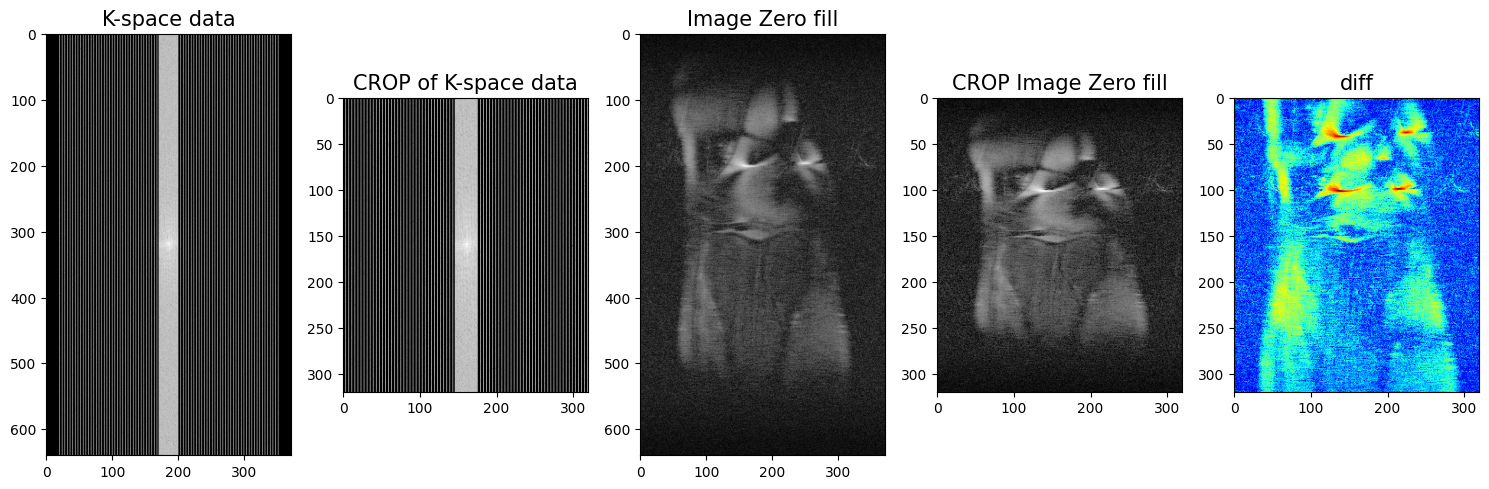

In [7]:
plt.figure(figsize = (20,20))
# for i in range(1,6):
#     plt.subplot(1,5,i)
#     plt.imshow(np.log(np.abs(zerofill[i-1]) + 1e-12).cpu().numpy(), cmap = 'gray')
#     plt.title(f'Coil {i}')
# plt.tight_layout()
# plt.show()
plt.figure(figsize = (15,10))
plt.subplot(1,5,1)
plt.imshow(np.log(np.abs(ksp_sum) + 1e-12).cpu().numpy(), cmap = 'gray')
plt.title(f'K-space data',fontsize = 15)
plt.subplot(1,5,3)
plt.imshow(np.log(np.abs(img_sum) + 1e-5).cpu().numpy(), cmap = 'gray')
plt.title(f'Image Zero fill',fontsize = 15)
plt.subplot(1,5,2)
plt.imshow(np.log(np.abs(ksp_crop) + 1e-12).cpu().numpy(), cmap = 'gray',aspect = 1.2)
plt.title(f'CROP of K-space data',fontsize = 15)
plt.subplot(1,5,4)
plt.imshow(np.log(np.abs(img_crop) + 1e-5).cpu().numpy(), cmap = 'gray', aspect = 1.2)
plt.title(f'CROP Image Zero fill',fontsize = 15)
plt.subplot(1,5,5)
plt.imshow(np.log(np.abs(diff) + 1e-5).cpu().numpy(), cmap = 'jet', aspect = 1.2)
plt.title(f'diff',fontsize = 15)
plt.tight_layout()
plt.show()

### What about crop the frequency encoding?

In [8]:
zero_crop_fe = zerofill[:,160:480,:]
ksp_sum_fe = torch.sum(zerofill, dim=0)
img_sum_fe = physics.inverse_fourier_transform(ksp_sum)

ksp_crop_fe = torch.sum(zero_crop_fe, dim=0)
img_crop_fe = physics.inverse_fourier_transform(ksp_crop_fe)

diff_fe = img_sum_fe[160:480, :] - img_crop_fe

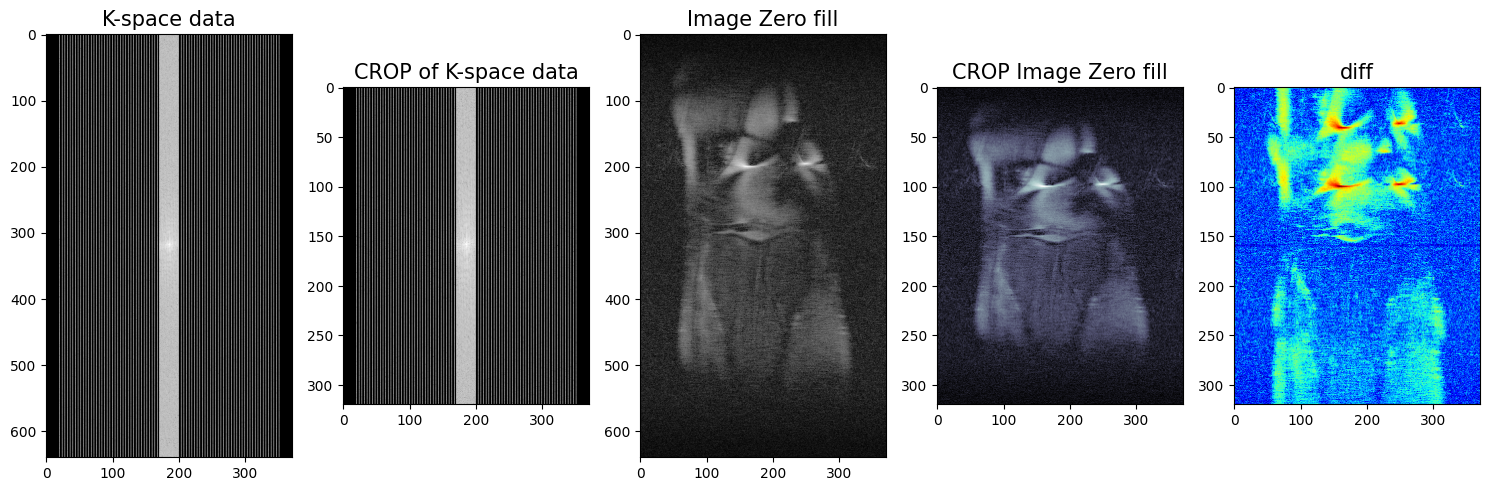

In [9]:
#plt.figure(figsize = (20,20))
# for i in range(1,6):
#     plt.subplot(1,5,i)
#     plt.imshow(np.log(np.abs(zerofill[i-1]) + 1e-12).cpu().numpy(), cmap = 'gray')
#     plt.title(f'Coil {i}')
# plt.tight_layout()
# plt.show()
plt.figure(figsize = (15,10))
plt.subplot(1,5,1)
plt.imshow(np.log(np.abs(ksp_sum_fe) + 1e-12).cpu().numpy(), cmap = 'gray')
plt.title(f'K-space data',fontsize = 15)
plt.subplot(1,5,3)
plt.imshow(np.log(np.abs(img_sum_fe) + 1e-5).cpu().numpy(), cmap = 'gray')
plt.title(f'Image Zero fill',fontsize = 15)
plt.subplot(1,5,2)
plt.imshow(np.log(np.abs(ksp_crop_fe) + 1e-12).cpu().numpy(), cmap = 'gray', aspect = 1.5)
plt.title(f'CROP of K-space data',fontsize = 15)
plt.subplot(1,5,4)
plt.imshow(np.log(np.abs(img_crop_fe) + 1e-5).cpu().numpy(), cmap = 'bone', aspect = 1.5)
plt.title(f'CROP Image Zero fill',fontsize = 15)
plt.subplot(1,5,5)
plt.imshow(np.log(np.abs(diff_fe) + 1e-5).cpu().numpy(), cmap = 'jet', aspect = 1.5)
plt.title(f'diff',fontsize = 15)
plt.tight_layout()
plt.show()

### Coil Reduction. How it works?

In [14]:
# 0. get the data
kspace, Image = getinfo()
ksp = kspace[15]
img = Image[15] # This has real small numbers


# 1. Initilization of two variables
sampler = SamplingFunction(accel_factor = 4, num_central_lines = 30)
physics = Physics(alpha=0.1, sampler=sampler)

# 2. Reconstruction (Coil reduction)
#Cs_completekspace = mr.app.EspiritCalib(ksp).run()
#sensitivities_normalized_cs_complete = Cs_completekspace / np.sqrt(np.sum(np.abs(Cs_completekspace)**2, axis=0, keepdims=True) + 1e-8)
#np.save('/shared/BIOE486/SP25/users/jgarca2/Dataset/Small_sensitivity_map/sensitivities_normalized_cs_complete.npy', sensitivities_normalized_cs_complete)
sensitivities_normalized_cs_complete = np.load('/shared/BIOE486/SP25/users/jgarca2/Dataset/Small_sensitivity_map/sensitivities_normalized_cs_complete.npy')
Cs_conj_complete = torch.conj(torch.from_numpy(sensitivities_normalized_cs_complete))

ksp_tensor = torch.from_numpy(ksp)
ksp_recon = physics.inverse_fourier_transform(ksp_tensor)
ksp_combine_0 = torch.sum(ksp_recon * Cs_conj_complete, dim = -3)
ksp_combine_1 = torch.sum(ksp_recon, dim = -3)
ksp_combine_2 = torch.sqrt(torch.sum(torch.abs(ksp_recon)**2, dim=-3))

print(f'img_norm                    min : {img.min()}    max : {img.max()}')
print(f'ksp_combine_0 sum(Ksp * Cs) min : {torch.abs(ksp_combine_0).min()}                      max : {torch.abs(ksp_combine_0).max()}')
print(f'ksp_combine_1 sum(Ksp)      min : {torch.abs(ksp_combine_1).min()}   max : {torch.abs(ksp_combine_1).max()}')
print(f'ksp_combine_2 Sos(Ksp)      min : {ksp_combine_2.min()}   max : {ksp_combine_2.max()}')

img_norm                    min : 6.836014563305071e-06    max : 0.0008325239759869874
ksp_combine_0 sum(Ksp * Cs) min : 0.0                      max : 0.0008318285690620542
ksp_combine_1 sum(Ksp)      min : 2.6314607382005306e-08   max : 0.0004289243370294571
ksp_combine_2 Sos(Ksp)      min : 2.3980096557352226e-06   max : 0.0008325239177793264


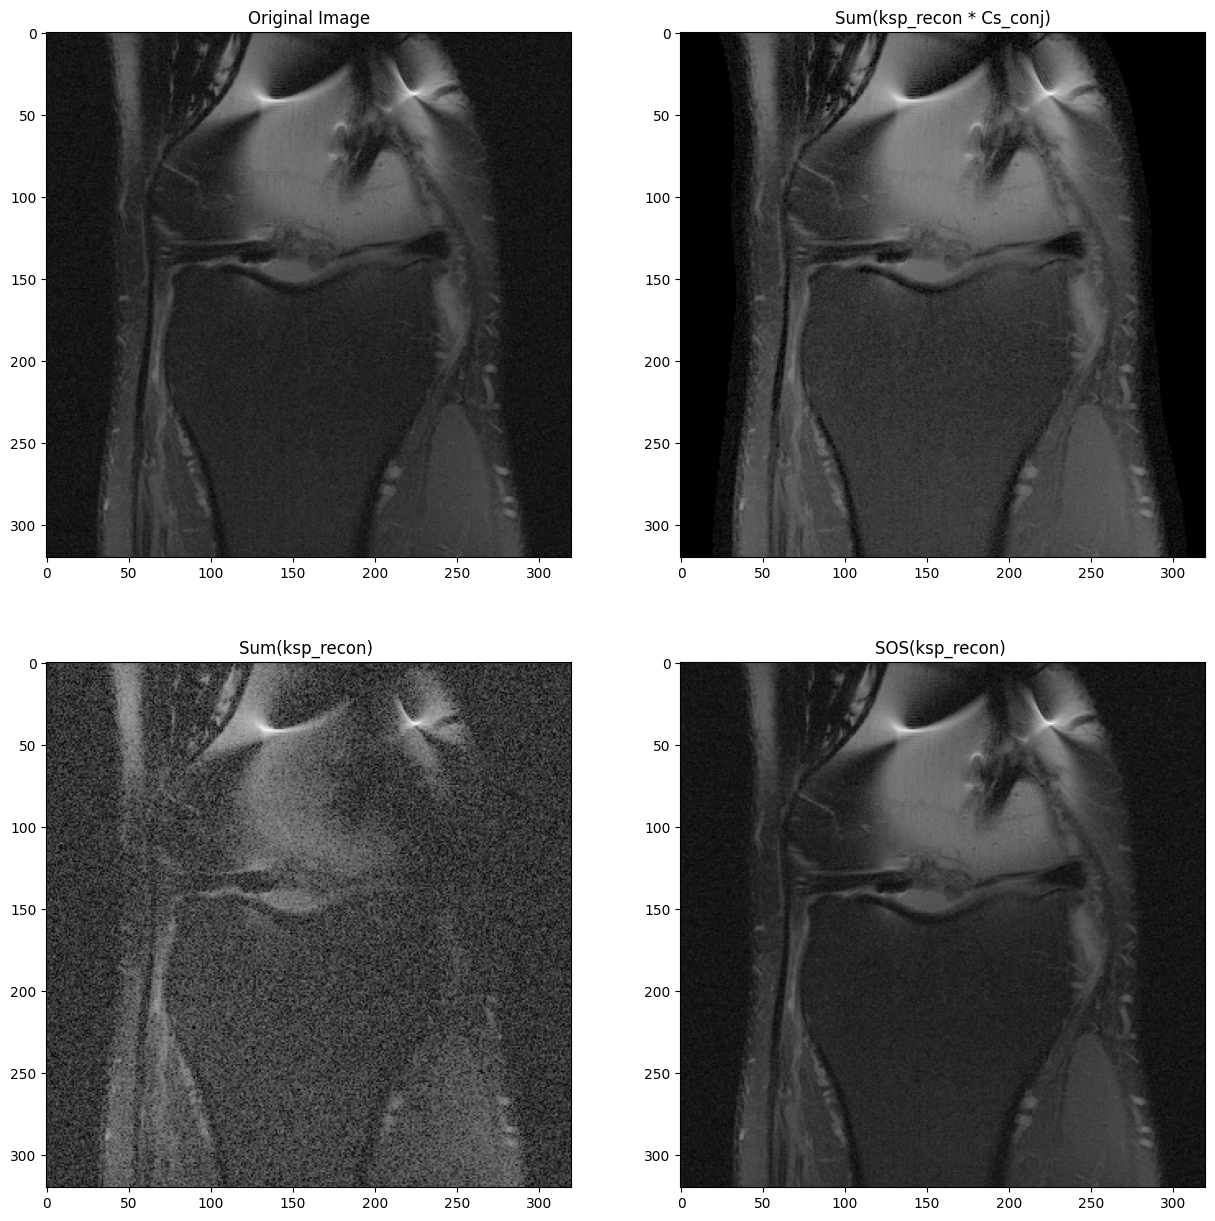

In [38]:
def safe_plot(img, eps=1e-5):
    """Safe log scaling that handles zeros and preserves your style"""
    return np.log(np.abs(img) + eps)

plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
plt.imshow(safe_plot(img), cmap = 'gray')
plt.title('Original Image')

plt.subplot(2,2,2)
plt.imshow(safe_plot(ksp_combine_0[160:480, 25:345]), cmap='gray')
plt.title('Sum(ksp_recon * Cs_conj)')

plt.subplot(2,2,3)
plt.imshow(safe_plot(ksp_combine_1[160:480, 25:345]), cmap='gray')
plt.title('Sum(ksp_recon) ')

plt.subplot(2,2,4)
plt.imshow(safe_plot(ksp_combine_2[160:480, 25:345]), cmap='gray')
plt.title('SOS(ksp_recon) ')
plt.show()


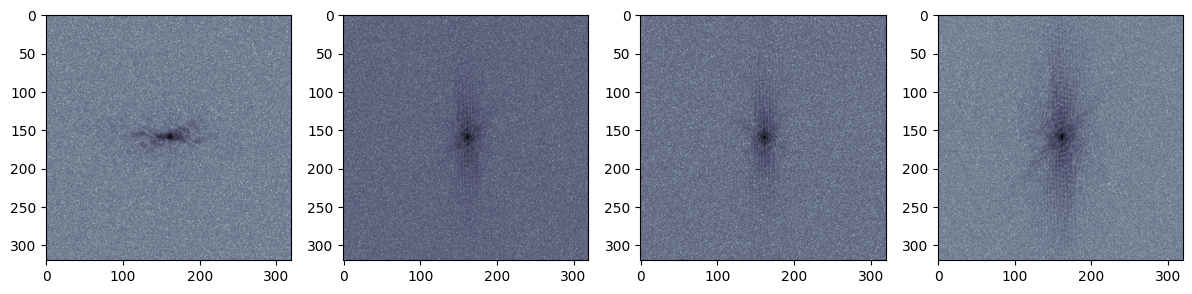

In [16]:
plt.figure(figsize = (15,15))
for i in range(1,5):
    plt.subplot(1,5,i)
    plt.imshow(np.log(np.abs(ksp[i][160:480, 25:345]+1e-6)), cmap = 'bone_r')
plt.tight_layout()
plt.show()

In [33]:
# 3. Undersample data SOS
undersample, _, _ = sampler.apply_mask(ksp)
zerofilled = sampler.zero_fill(undersample)
zerofilled_recon = physics.inverse_fourier_transform(zerofilled)
zerofilled_sos = torch.sqrt(torch.sum(torch.abs(zerofilled_recon)**2, dim=-3))

# 4. Undersample apply sensitivity map
Cs = mr.app.EspiritCalib(zerofilled.cpu().numpy()).run()
sensitivities_normalized_cs = Cs / np.sqrt(np.sum(np.abs(Cs)**2, axis=0, keepdims=True) + 1e-8)
#np.save('Data/sensitivities_normalized_cs.npy', sensitivities_normalized_cs)
#sensitivities_normalized_cs = np.load('/shared/BIOE486/SP25/users/jgarca2/Dataset/Small_sensitivity_map/sensitivities_normalized_cs_complete.npy')

Cs_conj = torch.conj(torch.from_numpy(sensitivities_normalized_cs))
zerofilled_CS = torch.sum(zerofilled_recon * Cs_conj, dim = -3)

print(f'zerofilled_sos_norm shape : {zerofilled_sos.shape} min : {zerofilled_sos.min()} max : {zerofilled_sos.max()}')
print(f'zerofilled_Cs shape   : {torch.abs(zerofilled_CS).shape} min: {torch.abs(zerofilled_CS).min()} max: {torch.abs(zerofilled_CS).max()}')

EspiritCalib: 100%|██████████| 100/100 [00:05<00:00, 17.64it/s]


zerofilled_sos_norm shape : torch.Size([640, 372]) min : 1.4427376981984708e-06 max : 0.0005393537576310337
zerofilled_Cs shape   : torch.Size([640, 372]) min: 0.0 max: 0.0005388529389165342


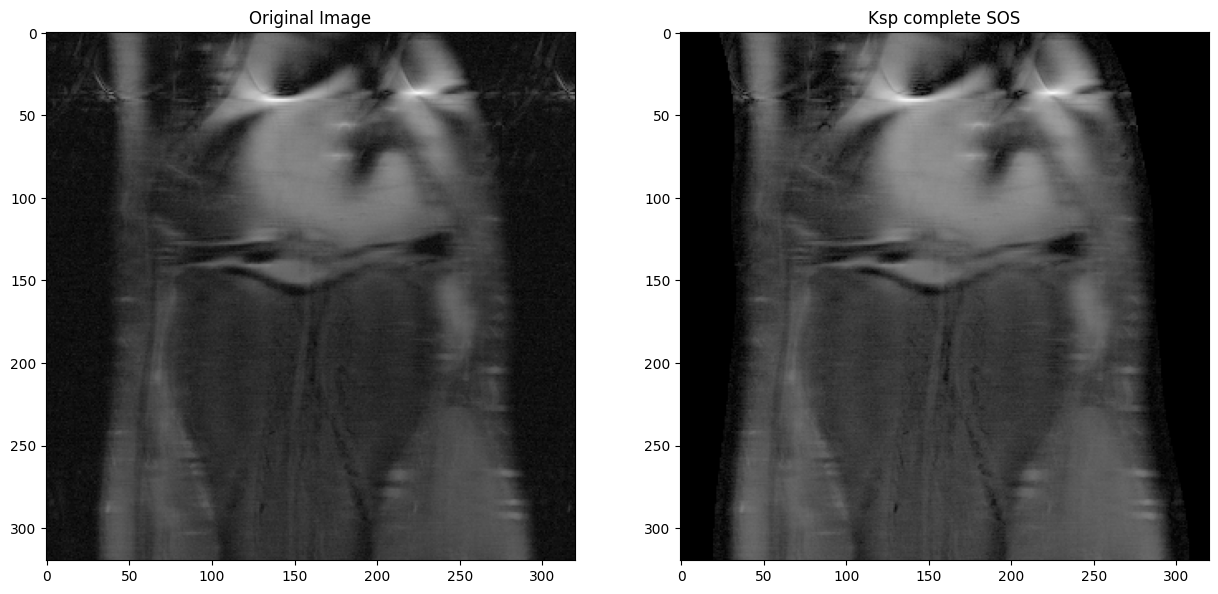

In [20]:
def safe_log(img, eps=1e-5):
    return np.log(np.abs(img) + eps)

plt.figure(figsize=(15, 15))
plt.subplot(1,2,1)
plt.imshow(safe_log(zerofilled_sos[160:480, 25:345]), cmap = 'gray')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(safe_log(zerofilled_CS[160:480, 25:345]), cmap='gray')
plt.title('Ksp complete SOS')

plt.show()

### How compute S and compute W_e works?


In [ ]:
plt.imshow(safe_log(zerofilled_CS, 1e-6), cmap='bone')
plt.show()

In [ ]:
physics = Physics(alpha=0.1, sampler=sampler)

Cs_tensor = torch.from_numpy(Cs)
S = physics._compute_S(zerofilled_CS, Cs_tensor)
W_e = physics._compute_W_e(undersample, Cs_tensor)
SW_e = physics._final_sum(S,W_e)

print(f'S {S.shape} W_e {W_e.shape} SW_e {SW_e.shape}')

In [ ]:
plt.figure(figsize = (20,20))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.imshow(safe_log(S[i+4],1e-5), cmap='gray')
    plt.title(f'S {i}')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (20,20))
for i in range(1,5):
    if i == 4:
        plt.subplot(1,4,4)
        plt.imshow(safe_log(SW_e, 1e-5), cmap='bone')
        plt.title(f'SW_e')
        break
    plt.subplot(1,4,i)
    plt.imshow(safe_log(W_e[i], 1e-5), cmap='bone')
    plt.title(f'W_e {i}')
plt.tight_layout()
plt.show()

### Can be something relate with orientation of phase encoding?

In [ ]:
combined_sos = torch.sqrt(torch.sum(torch.abs(ksp_tensor)**2, dim=1))

In [ ]:
import h5py
import numpy as np

def getinformation():
    fname_train = './data/file1000001.h5'

    with h5py.File(fname_train, 'r') as f:
        ls = list(f.keys())

        information = f.get('ismrmrd_header')

        kspace_TRAIN = f.get('kspace')
        kspace_TRAIN = np.array(kspace_TRAIN)

        high_resolution_TRAIN = f.get('reconstruction_rss')
        high_resolution_TRAIN = np.array(high_resolution_TRAIN)
        #f.close()
    return ls, information, kspace_TRAIN, high_resolution_TRAIN

In [ ]:
ls, info, kspace_TRAIN, high_resolution_TRAIN = getinformation()

In [ ]:
info # Read this with XML reader.